<a href="https://colab.research.google.com/github/waelrash1/predictive_analytics_DT302/blob/main/sentiment_%2B_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM

# Dataset Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

Content
It contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

Acknowledgements
The official link regarding the dataset with resources about how it was generated is here
The official paper detailing the approach is here

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

Inspiration
To detect severity from tweets. You may have a look at this.



In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix
# Natural Language
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer


In [ ]:
stopwords.append('http')
stopwords

## Dataset
To train our sentiment analysis model, we use a sample of tweets from the sentiment140 dataset. This dataset contains 1.6 million tweets that have been classified as having either a positive or negative sentiment. sing the code below we load the entire dataset. 1,600,000 rows is a lot of data especially considering we will have to clean the text and create features from it. So, to make things more manageable, in line 9, we take a random sample of 50,000 tweets.

https://www.kaggle.com/kazanova/sentiment140?select=training.1600000.processed.noemoticon.csv

In [ ]:
#load dataset
data = pd.read_csv('https://raw.githubusercontent.com/waelrash1/predictive_analytics_DT302/main/training.30000.processed.noemoticon.csv',
                    encoding='latin-1',
                    header = None,
                    usecols=[0,5],
                    names=['target','text'])
#random sample
data = data.sample(n=5000,random_state=100).reset_index(drop=True)
data['text']= data['text'].astype(str)


In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
def clean_text(text):
    """
    Return clean text
    params
    ------------
        text: string
    """

    text = text.lower() #lowercase
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if not t in stopwords] #remove stopwords
    tokens = [t for t in tokens if t.isalnum()] #remove punctuation
    text_clean = " ".join(tokens)
    
    return text_clean

#clean text 
data['textCleaned'] = [clean_text(text) for text in data['text']]



In [ ]:

data.dropna().count()
data= data.dropna()

## Feature engineering (bag-of-words)
Even after cleaning, like all ML models, SVMs cannot understand text. What we mean by this is that our model cannot take in the raw text as an input. We have to first represent the text in a mathematical way. In other words, we must transform the tweets into model features. One way to do this is by using N-grams.
N-grams are sets of N consecutive words. In Figure 2, we see an example of how a sentence is broken down into 1-grams (unigrams) and 2-grams (bigrams). Unigrams are just the individual words in the sentence. Bigrams are the set of all two consecutive words. Trigrams (3-grams) would be the set of all 3 consecutive words and so on. You can represent text mathematically by simply counting the number of times certain N-grams occur.

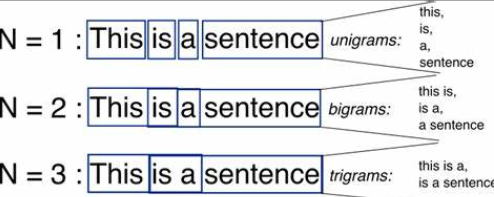

For our problem, we take the 1000 most common unigrams/ bigrams from our tweets. That is, we count the number of times these N-grams occur in our corpus of cleaned tweets and take the top 1000. To create model features, we then count the number of times these N-grams occur in each of the tweets. This approach is known as bag-of-words.
Table 3 gives an example of a feature matrix created using this approach. The top row gives each of the 1000 N-grams. There is a numbered row for each of the tweets. The numbers within the matrix give the number of times that N-gram occurs within the tweet. For example, “sorry” occurs once in tweet 2. Essentially, we are representing each of tweets as a vector. In other words, we are vectorising our tweets using counts of N-grams.


In [ ]:
len(data)
data.sample(10)

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X=data['textCleaned']
y=data['target']
X_train_t,X_test_t, y_train,  y_test=train_test_split(X,y,test_size=0.2)
#train = data[0:40000]
#test = data[40000:50000].reset_index(drop=True)

# Create count vectoriser 
vectorizer = CountVectorizer(ngram_range=(1, 2)
                            ,max_features=1000)

# Transform training corpus into feature matrix
X = vectorizer.fit_transform(X_train_t)
feature_names = vectorizer.get_feature_names()

X_train = pd.DataFrame(data=X.toarray(),columns=feature_names)
#y_train = train['target']

In [ ]:
len(X_train)
len(y_train)

In [ ]:
X_train.sample(5)

In [ ]:
# Transform testing corpus into feature matrix
X = vectorizer.transform(X_test_t.astype(str))

X_test = pd.DataFrame(data=X.toarray(),columns=feature_names)
#y_test = test['target']

In [ ]:
# Min-Max scalling
x_max = X_train.max()
x_min = X_train.min()

X_train = (X_train - x_min)/x_max
X_test = (X_test - x_min)/x_max

In [ ]:
X_train.sample(5)

## Modelling

In [ ]:
#fit SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', C=.75).fit(X_train, y_train)

#get predictions on test set
y_pred_tr = model.predict(X_train)
y_pred = model.predict(X_test)
accuracy_tr = accuracy_score(y_train,y_pred_tr)
#accuracy on test set
accuracy = accuracy_score(y_test,y_pred)
print("Train Accuracy: {}".format(accuracy_tr))
print("Test Accuracy: {}".format(accuracy))

In [ ]:
#create confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data = conf_matrix,
                              columns=['negative','positive'],
                              index=['negative','positive'])

#plot confusion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.ylabel('Actual',size=20)
plt.xlabel('Predicted',size=20)

In [ ]:
y_train.value_counts()

In [ ]:
# fit a svm on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

model = SVC(gamma='scale')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))


Resampling Technique
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and/or adding more examples from the minority class (over-sampling).

Class Imbalance: Undersampling and Oversampling

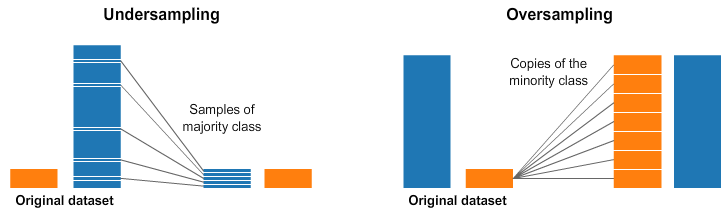

In [ ]:
# class count
class_count_0, class_count_1 =   y_train.value_counts()

# Separate class
negative_sent = y_train[y_train == 0.0]
positive_sent = y_train[y_train != 0.0]# print the shape of the class
print('Negative class 0:', negative_sent.shape)
print('Positive class 1:', positive_sent.shape)

## Random Under-Sampling
Undersampling can be defined as removing some observations of the majority class. This is done until the majority and minority class is balanced out.

Undersampling can be a good choice when you have a ton of data -think millions of rows. But a drawback to undersampling is that we are removing information that may be valuable.

In [ ]:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",test_under['Class'].value_counts())# plot the count after under-sampeling
test_under['Class'].value_counts().plot(kind='bar', title='count (target)')

# TF-IDF Vectorizer 
TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
# set of documents
X=data['textCleaned']
y=data['target']
X_train_t,X_test_t, y_train,  y_test=train_test_split(X,y,test_size=0.2)
# instantiate the vectorizer object
#countvectorizer = CountVectorizer(analyzer= 'word', stop_words='english')
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
# convert th documents into a matrix
#count_wm = countvectorizer.fit_transform(train)
tfidf_wm = tfidfvectorizer.fit_transform(X_train_t)


In [ ]:
tfidf_tokens = tfidfvectorizer.get_feature_names()

X_train = pd.DataFrame(data = tfidf_wm.toarray(),columns = tfidf_tokens)

print("\nTD-IDF Vectorizer\n")
print(X_train)



In [ ]:
# Transform testing corpus into feature matrix
X = tfidfvectorizer.transform(X_test_t.astype(str))

X_test = pd.DataFrame(data=X.toarray(),columns=tfidf_tokens)
#y_test = test['target']

In [ ]:
# Modelling
#fit SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1).fit(X_train, y_train)

#get predictions on test set
y_pred = model.predict(X_test)

#accuracy on test set
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy: {}".format(accuracy))

In [ ]:
#create confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
conf_matrix = pd.DataFrame(data = conf_matrix,
                              columns=['negative','positive'],
                              index=['negative','positive'])

#plot confusion matrix
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.ylabel('Actual',size=20)
plt.xlabel('Predicted',size=20)

In [ ]:
# fit a svm on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

model = SVC(gamma='scale')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize performance
print('Mean Accuracy: %.3f' % mean(scores))